Bài toán phân loại đa lớp dựa trên tập cơ sở dữ liệu CIFAR-10, bao gồm 60000 ảnh kích thước 32x32 đã được gắn nhãn. Thí nghiệm sử dụng mạng CNN bao gồm 2 lớp convolutional với 32 channel và 2 lớp convolutional với 64 channel, các lớp này đều có kích thước kernel là 3x3. Lớp fully connected ở cuối có kích thước 512. Có thể thấy hai thuật toán ADAM và AMSGRAD có hiệu quả ngang ngửa nhau. Điều này cho thấy rằng các kết luận trong bài báo chưa thật chuẩn xác và cần phải xem xét nhiều hơn khi so sánh giữa ADAM và AMSGRAD. 

In [0]:
%tensorflow_version 1.x 

#Train a simple deep CNN on the CIFAR10 small images dataset
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 128
num_classes = 10
epochs = 25
data_augmentation = True
num_predictions = 20


# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    
    # initiate optimizers

    adam_opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    ams_opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    # Let's train the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam_opt,
                  metrics=['accuracy'])
    model.save_weights('model.h5')

    # Fit the model on the batches generated by datagen.flow().
    history_adam = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)
    
    model.load_weights('model.h5')
    model.compile(loss='categorical_crossentropy',
                  optimizer=ams_opt,
                  metrics=['accuracy'])
    history_ams = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

TensorFlow 1.x selected.


Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Using real-time data augmentation.

Epoch 1/25
391/391 [==============================] - 249s 637ms/step - loss: 1.7492 - accuracy: 0.3527 - val_loss: 1.3423 - val_accuracy: 0.5074
Epoch 2/25
391/391 [==============================] - 244s 623ms/step - loss: 1.4000 - accuracy: 0.4952 - val_loss: 1.1394 - val_accuracy: 0.5952
Epoch 3/25
391/391 [==============================] - 249s 637ms/step - loss: 1.2359 - accuracy: 0.5580 - val_loss: 1.0162 - val_accuracy: 0.6364
Epoch 4/25
391/391 [==============================] - 247s 633ms/step - loss: 1.1256 - accuracy: 0.6004 - val_loss: 0.9355 - val_accuracy: 0.6660
Epoch 5/25
391/391 [==============================] - 247s 632ms/step - loss: 1.0566 - accuracy: 0.6242 - val_loss: 0.9740 - val_accuracy: 0.6611
Epoch 6/25
391/391 [==============================] - 251s 643ms/step - loss: 0

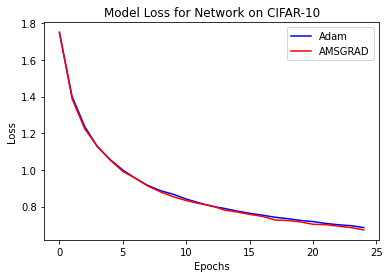

In [0]:
import matplotlib.pyplot as plt

plt.plot(history_adam.history['loss'],label='Adam',color=(0,0,1))
plt.plot(history_ams.history['loss'],label='AMSGRAD',color=(1,0,0))

plt.title('Model Loss for Network on CIFAR-10')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()